In [283]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from DLC_for_WBFM.utils.general.postprocessing.utils_metadata import regionprops_one_volume_one_channel
from collections import defaultdict
from DLC_for_WBFM.utils.neuron_matching.utils_gaussian_process import upsample_using_gaussian_process
from segmentation.util.utils_postprocessing import get_brightness_per_plane
from segmentation.util.utils_postprocessing import calc_split_point_via_brightnesses
from skimage.measure import label, regionprops
import zarr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from segmentation.util.utils_pipeline import perform_post_processing_2d

In [3]:
# fname = "/scratch/zimmer/Charles/dlc_stacks/project_pytest/project_config.yaml"
fname = "/home/charles/dlc_stacks/students-worm4-LOCAL/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname, to_load_tracklets=True, to_load_segmentation_metadata=True)

INFO:projectDataLogger:Starting threads to read data...
INFO:projectDataLogger:First time loading the all tracklets, may take a while...


File for mode automatic exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/students-worm4-LOCAL/3-tracking/postprocessing/combined_3d_tracks.h5


File for mode manual exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/students-worm4-LOCAL/3-tracking/manual_annotation/manually_split_tracklets-3.h5


  0%|          | 0/26890 [00:00<?, ?it/s]

INFO:projectDataLogger:Read all data


File for mode manual exists at precendence: 1/2
Read data from: /home/charles/dlc_stacks/students-worm4-LOCAL/3-tracking/manual_annotation/global2tracklet_manual-3.pickle
Project data for directory:
/home/charles/dlc_stacks/students-worm4-LOCAL 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     True
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



# Use Lukas' 20 volume ground truth

In [284]:
mask_fname = "/home/charles/Current_work/ground_truth/masks_cropped.zarr/"
gt_mask = zarr.open(mask_fname)

red_fname = "/home/charles/Current_work/ground_truth/red_cropped.zarr/"
gt_red = zarr.open(red_fname)

In [286]:
# v = napari.view_image(gt_red, ndisplay=3)
# v.add_labels(gt_mask)

# Manipulate the ground truth to remove dim pixels

In [329]:
from skimage.filters import threshold_otsu, threshold_local
import skimage
from DLC_for_WBFM.utils.nn_utils.modify_segmentation import remove_local_percentile
from magicgui import magicgui
from napari.types import LayerDataTuple

@magicgui(call_button="remove")
def remove(viewer: napari.Viewer, sigma=1, percentile=10) -> LayerDataTuple:
    
    seg_dat, filtered_red = remove_local_percentile(viewer, sigma, percentile)
        
    print("Finished")
    
    return [(seg_dat, {'name': 'filtered_seg'}, 'labels'), 
            (filtered_red, {'name': 'filtered_red'}, 'image')]

In [324]:
viewer = napari.view_image(gt_red, name='red_dat', ndisplay=3)
viewer.add_labels(gt_mask, name="seg_dat")

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Labels layer 'seg_dat' at 0x7f6938ff4910>

In [330]:
viewer.window.add_dock_widget(remove)

Looping
Finished


In [331]:
new_mask_fname = "/home/charles/Current_work/ground_truth/masks_shrunk_25percentile.zarr/"
new_mask = zarr.open_like(gt_mask, new_mask_fname)

In [333]:
percentile = 25

for t in range(gt_mask.shape[0]):
    red, seg = gt_red[t,...], gt_mask[t,...]
    new_seg, _ = remove_local_percentile(percentile, red, seg, sigma=1)
    new_mask[t,...] = new_seg

Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping
Looping


# Do some approximate ground truth comparisons using one volume

Note that some neurons have already been mis-segmented, e.g. 3-neuron stacks that were split in the middle

In [ ]:
t = 1

full_mask = project_data.raw_segmentation[t, ...]
red_volume = project_data.red_data[t, ...]

seg_ind = np.unique(full_mask)[1:]

In [173]:
gt_num_segs = dict()#defaultdict(lambda : 1)

gt_num_segs[67] = 3

gt_num_segs[10] = 2
gt_num_segs[113] = 2
gt_num_segs[136] = 2
gt_num_segs[6] = 2
gt_num_segs[8] = 2
gt_num_segs[34] = 2
gt_num_segs[35] = 2
gt_num_segs[10] = 2
gt_num_segs[84] = 2
gt_num_segs[23] = 2
gt_num_segs[39] = 2

# Messy
# i = [136, 35]
# i = [132, 23]
# i = [43, 138] # Was 3, then improperly split... could be good in xy
# gt_num_segs[136] = 2
# gt_num_segs[132] = 2
# gt_num_segs[43] = 2

for i in seg_ind:
    if i not in gt_num_segs:
        gt_num_segs[i] = 1

In [199]:
naive_num_segs = dict()
upsample_num_segs = dict()

opt = dict(plots=1)

======================8========================


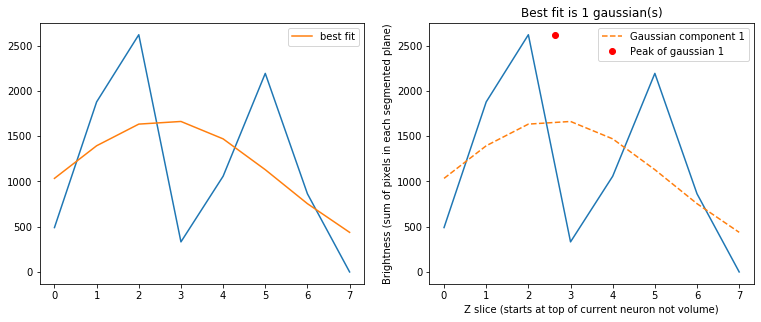

['Single gaussian (aicc): [118.40135505682538, 173.8031150934856]']


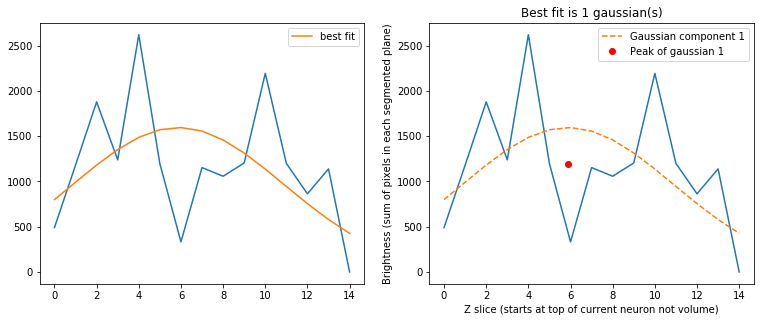

In [242]:
seg_ind = [8]
for i_target in seg_ind:
    print(f"======================{i_target}========================")
    brightness_per_plane, individual_plane_masks, planes_where_neuron_exists = get_brightness_per_plane(full_mask,
                                                                                                        i_target,
                                                                                                        red_volume)
    if len(brightness_per_plane) < 7:
        naive_num_segs[i_target] = 1
        upsample_num_segs[i_target] = 1
        continue
    
    x_split_local_coord, explanation = calc_split_point_via_brightnesses(brightness_per_plane, min_separation=None, **opt)
    
    print(explanation)
    if x_split_local_coord is None:
        naive_num_segs[i_target] = 1
    elif np.isscalar(x_split_local_coord):
        naive_num_segs[i_target] = 2
    else:
        naive_num_segs[i_target] = 3
    
    brightness_upsampled, gp, _ = upsample_using_gaussian_process(brightness_per_plane, 15)
    x_split_local_coord, explanation = calc_split_point_via_brightnesses(brightness_upsampled, min_separation=None, **opt)
    
    if x_split_local_coord is None:
        upsample_num_segs[i_target] = 1
    elif np.isscalar(x_split_local_coord):
        upsample_num_segs[i_target] = 2
    else:
        upsample_num_segs[i_target] = 3

In [229]:
from segmentation.util.util_curve_fitting import calculate_multi_gaussian_fits, plot_gaussians, get_best_model_using_aicc, aicc_correction

In [224]:
mods = calculate_multi_gaussian_fits(brightness_per_plane, 14)

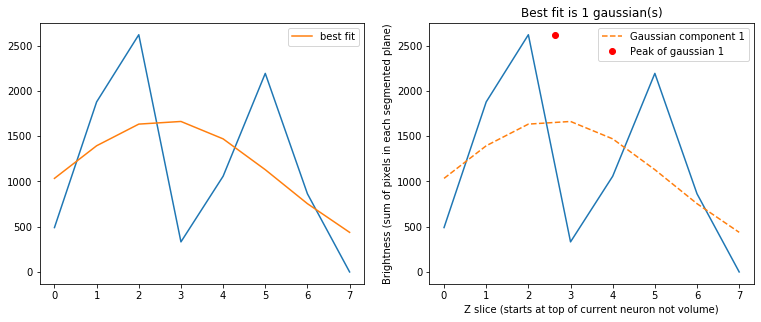

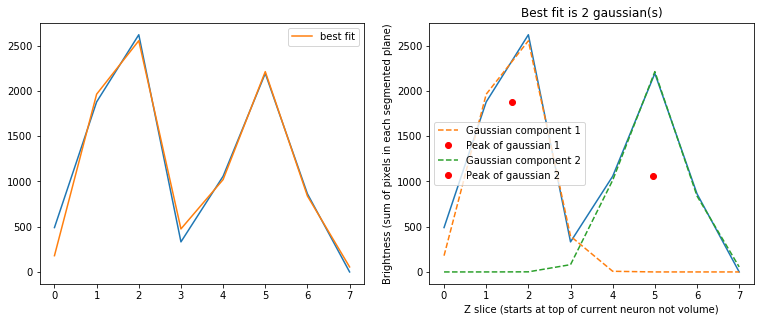

(0, [118.40135505682538, 173.8031150934856])


In [225]:
plot_gaussians(mods[0], None)
plot_gaussians(mods[1], None)
print(get_best_model_using_aicc(mods))

In [239]:
aicc_correction(6, 10), aicc_correction(3, 10)

(28.0, 4.0)

In [236]:
mods[1].aic, mods[0].aic

(89.8031150934856, 112.40135505682538)

  0%|          | 0/140 [00:00<?, ?it/s]

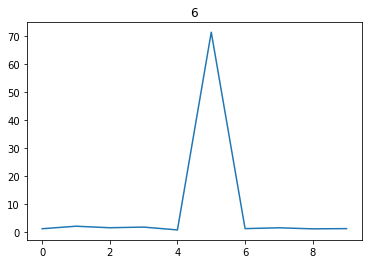

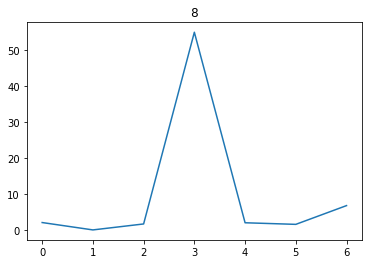

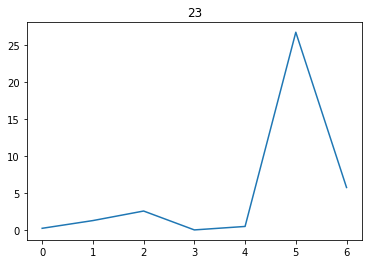

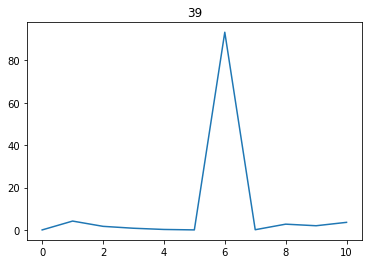

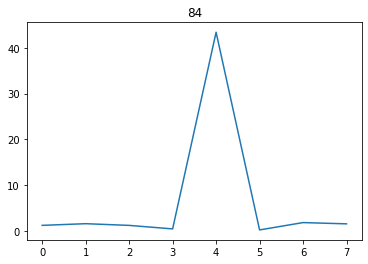

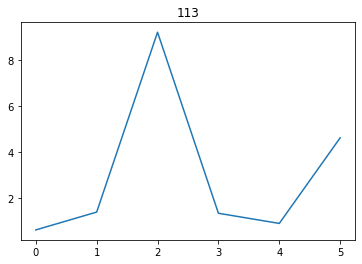

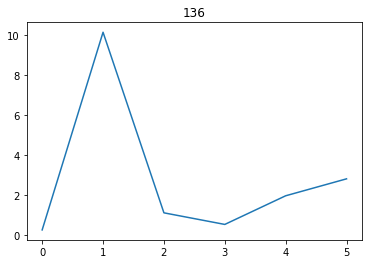

In [183]:
centroid_num_segs = dict()
for i_target in tqdm(seg_ind):
    
    xy = get_centroid_diff(full_mask, red_volume, i_target)
    if len(xy) < 6:
        centroid_num_segs[i_target] = 1
        continue
        
    x_split_local_coord = get_split_point_from_centroids(xy, threshold=6)
    
    if x_split_local_coord == len(xy)-1 or x_split_local_coord == 0:
        centroid_num_segs[i_target] = 1
        continue
    
    if x_split_local_coord is None:
        centroid_num_segs[i_target] = 1
    elif np.isscalar(x_split_local_coord):
        centroid_num_segs[i_target] = 2
        plt.plot(xy)
        plt.title(i_target)
        plt.show()
    else:
        centroid_num_segs[i_target] = 3

In [184]:
def compare_to_gt_seg(gt_num_segs, computed_num_segs):
    naive2gt = dict(correct=0, undersegmentation=0, oversegmentation=0, fixed=0)
    mistakes = {}
    for i, gt_val in gt_num_segs.items():
        computed_val = computed_num_segs[i]
        if computed_val == gt_val:
            naive2gt['correct'] += 1
            if gt_val > 1:
                naive2gt['fixed'] += 1
        elif computed_val < gt_val:
            naive2gt['undersegmentation'] += 1
            mistakes[i] = 'undersegmentation'
        elif computed_val > gt_val:
            naive2gt['oversegmentation'] += 1
            mistakes[i] = 'oversegmentation'
    return naive2gt, mistakes



In [185]:
naive2gt, naive_mistakes = compare_to_gt_seg(gt_num_segs, naive_num_segs)
upsample2gt, upsample_mistakes = compare_to_gt_seg(gt_num_segs, upsample_num_segs)
centroid2gt, centroid_mistakes = compare_to_gt_seg(gt_num_segs, centroid_num_segs)

In [187]:
df = pd.concat([pd.DataFrame(naive2gt, index=['naive']), pd.DataFrame(upsample2gt, index=['upsample']), pd.DataFrame(centroid2gt, index=['centroid'])])
# sns.barplot(data=df)
df

,correct,undersegmentation,oversegmentation,fixed
naive,130,10,0,1
upsample,120,2,18,9
centroid,136,4,0,7


In [135]:
naive_mistakes, upsample_mistakes

({67: 'undersegmentation',
  10: 'undersegmentation',
  113: 'undersegmentation',
  8: 'undersegmentation',
  34: 'undersegmentation',
  35: 'undersegmentation',
  84: 'undersegmentation'},
 {67: 'undersegmentation',
  10: 'undersegmentation',
  113: 'undersegmentation',
  8: 'undersegmentation',
  34: 'undersegmentation',
  35: 'undersegmentation',
  39: 'oversegmentation',
  60: 'oversegmentation'})

# Try a sine model

In [277]:
from lmfit.models import SineModel, ConstantModel

In [278]:
mod = SineModel()
pars = mod.make_params(amplitude=1000, frequency=1, shift=0)

c = ConstantModel()
pars.update(c.make_params(constant=1000))

mod = mod + c


In [279]:
y = brightness_per_plane
y -= np.min(y)
x = list(range(len(y)))
result = mod.fit(data=y, params=pars, x=x)

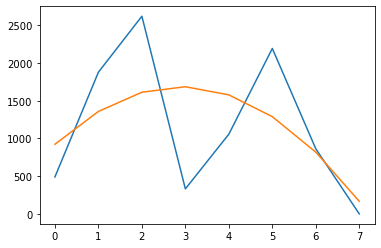

In [280]:
# comps = result.eval_components(x=np.array(x))
plt.plot(x, y)
plt.plot(result.best_fit)

In [281]:
x

[0, 1, 2, 3, 4, 5, 6, 7]